# Amazon Sentiment Analysis



Import data from Kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'amazon-fine-food-reviews' dataset.
Path to dataset files: /kaggle/input/amazon-fine-food-reviews


In [2]:
# =========================
# CORE / DATA HANDLING
# =========================
import os
import pandas as pd
import numpy as np

# =========================
# MODELLING & PREPROCESSING
# =========================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# =========================
# EVALUATION
# =========================
from sklearn.metrics import classification_report, confusion_matrix

# =========================
# VISUALISATION
# =========================
import matplotlib.pyplot as plt
import seaborn as sns


Get data from path, check head

In [3]:
csv_path = os.path.join(path, "Reviews.csv")
print("Loading:", csv_path)

df = pd.read_csv(csv_path)
df.head(2)

Loading: /kaggle/input/amazon-fine-food-reviews/Reviews.csv


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [4]:
import os
print(os.listdir(path))

['hashes.txt', 'Reviews.csv', 'database.sqlite']




---
---


## Data Handling

---

---



Info

In [5]:
df.shape

(568454, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Null values

In [7]:
df.isna().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


Cleaning null values (removing)

In [8]:
cols_with_na = ["ProfileName", "Summary"]

df_clean = df.dropna(subset=cols_with_na)

print(df.shape)      # before
print(df_clean.shape)  # after


(568454, 10)
(568401, 10)


As it is a very big data set, we will remove those values

In [9]:
df = df_clean

In [10]:
df.shape

(568401, 10)

In [11]:
df = df.drop_duplicates(subset=["Text"])

In [12]:
df.shape

(393560, 10)

In [13]:
df = df.dropna(subset=["Text"]) # this column doesn't do anything

In [14]:
df.shape

(393560, 10)

In [15]:
# we lost ~~ 170k rows, still a good number as we are with 393k,
# most of the lost reviews might have been duplicates like "love it!", "great!" same phrases
# check with terri to see if she thinks its too much if too muhc can remove duplicate on same producs/same user id
# if not keep as it is

# less aggressive: only drop if user wrote the same text for the same product
#df = df.drop_duplicates(subset=["UserId", "ProductId", "Text"])



---


Defining 4 sentiments for the analysis

In [16]:
def score_to_sentiment_4(score):
    if score <= 2:
        return "negative"
    elif score == 3:
        return "neutral"
    elif score == 4:
        return "positive"
    else:  # score == 5
        return "very_positive"

df["sentiment_4"] = df["Score"].apply(score_to_sentiment_4)

In [17]:
print(df["sentiment_4"].value_counts())
print(df["sentiment_4"].value_counts(normalize=True))

sentiment_4
very_positive    250705
negative          57062
positive          56041
neutral           29752
Name: count, dtype: int64
sentiment_4
very_positive    0.637018
negative         0.144989
positive         0.142395
neutral          0.075597
Name: proportion, dtype: float64




---


Adding text lenght and word count columns

In [18]:
# adding two columns text len the n of characters per review
# and word count the n of words per review

df["text_len"] = df["Text"].str.len()
df["word_count"] = df["Text"].str.split().str.len()


In [19]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment_4,text_len,word_count
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,very_positive,263,48
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative,190,31


Checking stats of both new columns

In [20]:
df[["word_count", "text_len"]].describe()


,word_count,text_len
count,393560.000000,393560.000000
mean,79.754599,433.837710
std,77.163528,433.008823
min,3.000000,12.000000
25%,34.000000,181.000000
50%,57.000000,304.000000
75%,97.000000,527.000000
max,3432.000000,21409.000000




---


Removing rows where word count is less than 10
<br>
Removing reviews with fewer than 10 words helps reduce noise and make the model learn from actual sentences instead of tiny, uninformative comments.



In [21]:
# how many rows would we drop if we put < 10
to_drop = df[df["word_count"] < 10]
print(len(to_drop))

63


In [22]:
# how are these rows distributed across the 4 sentiments defined
print(to_drop["sentiment_4"].value_counts())

sentiment_4
very_positive    49
negative          6
positive          5
neutral           3
Name: count, dtype: int64


In [23]:
df = df[df["word_count"] >= 10]

In [24]:
df.shape

(393497, 13)

In [25]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,text_len,word_count
count,393497.000000,393497.000000,393497.000000,393497.000000,3.934970e+05,393497.000000,393497.000000
mean,261288.549275,1.733500,2.203465,4.179226,1.296493e+09,433.899412,79.766156
std,167030.227172,6.874084,7.535993,1.311997,4.835044e+07,433.015990,77.164296
min,1.000000,0.000000,0.000000,1.000000,9.393408e+08,43.000000,10.000000
25%,112559.000000,0.000000,0.000000,4.000000,1.271462e+09,182.000000,34.000000
50%,248705.000000,0.000000,1.000000,5.000000,1.311725e+09,304.000000,57.000000
75%,407098.000000,2.000000,2.000000,5.000000,1.332979e+09,527.000000,97.000000
max,568454.000000,866.000000,923.000000,5.000000,1.351210e+09,21409.000000,3432.000000




---

Doing the same for 20 words

In [26]:
# how many rows would we drop if we put > 20
to_drop = df[df["word_count"] < 20]
print(len(to_drop))

11371


In [27]:
# how are these rows distributed across the 4 sentiments defined
print(to_drop["sentiment_4"].value_counts())

sentiment_4
very_positive    8373
positive         1487
negative          965
neutral           546
Name: count, dtype: int64


In [28]:
df = df[df["word_count"] >= 20]

In [29]:
df.shape

(382126, 13)



---

Doing the same, but this time for reviews with word count > 1000 (total of 133 rows). These are rare outliers (≈0.03% of data), much longer than normal reviews





In [30]:
# define the threshold
THRESH = 1000

# boolean mask: True for rows you'd drop
to_drop_mask = df["word_count"] >= THRESH

# how many rows is that?
num_to_drop = to_drop_mask.sum()
print("Rows to drop:", num_to_drop)

# optionally, look at them
rows_to_drop = df[to_drop_mask]
rows_to_drop[["Text", "word_count"]].head()


Rows to drop: 133


,Text,word_count
8756,And we find her here upon this grand amazon!<b...,1513
9849,I waited quite a while before following my imp...,1390
10004,"We breastfeed our month old boy, but since his...",1751
20419,Most people know that cats can be finicky eate...,1215
29109,"QUALITY<br />In my opinion, having used a doze...",1377


In [31]:
# how are those rows distributed across your 4 sentiments
print(rows_to_drop["sentiment_4"].value_counts())

sentiment_4
very_positive    75
positive         24
negative         22
neutral          12
Name: count, dtype: int64


In [32]:
df = df[df["word_count"] <= 2000]

In [33]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,text_len,word_count
count,382120.000000,382120.000000,382120.000000,382120.000000,3.821200e+05,382120.000000,382120.000000
mean,261160.959547,1.740534,2.202143,4.170774,1.298138e+09,443.845805,81.607082
std,167020.722889,6.894080,7.550392,1.317126,4.756192e+07,431.424435,76.956589
min,1.000000,0.000000,0.000000,1.000000,9.393408e+08,51.000000,20.000000
25%,112401.750000,0.000000,0.000000,4.000000,1.275264e+09,190.000000,35.000000
50%,248590.500000,0.000000,1.000000,5.000000,1.313280e+09,313.000000,58.000000
75%,406902.250000,2.000000,2.000000,5.000000,1.333670e+09,537.000000,99.000000
max,568454.000000,866.000000,923.000000,5.000000,1.351210e+09,11321.000000,1901.000000


In [34]:
df.shape

(382120, 13)



---



---



In [35]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment_4,text_len,word_count
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,very_positive,263,48
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative,190,31


Adding format for time column for better reading

In [36]:
df["review_time"] = pd.to_datetime(df["Time"], unit="s")

In [37]:
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment_4,text_len,word_count,review_time
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,very_positive,263,48,2011-04-27


Converted Unix Time to datetime review_time for readability, then dropped the original Time column

In [38]:
df = df.drop(columns=["Time"])

For extra cleanesses will check for white spaces, beggining and end

In [39]:
df["Text"] = df["Text"].str.strip()
df["Summary"] = df["Summary"].str.strip()

Last describe to look at stats

In [40]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,text_len,word_count,review_time
count,382120.000000,382120.000000,382120.000000,382120.000000,382120.000000,382120.000000,382120
mean,261160.959547,1.740534,2.202143,4.170774,443.845805,81.607082,2011-02-19 17:47:47.639484928
min,1.000000,0.000000,0.000000,1.000000,51.000000,20.000000,1999-10-08 00:00:00
25%,112401.750000,0.000000,0.000000,4.000000,190.000000,35.000000,2010-05-31 00:00:00
50%,248590.500000,0.000000,1.000000,5.000000,313.000000,58.000000,2011-08-14 00:00:00
75%,406902.250000,2.000000,2.000000,5.000000,537.000000,99.000000,2012-04-06 00:00:00
max,568454.000000,866.000000,923.000000,5.000000,11321.000000,1901.000000,2012-10-26 00:00:00
std,167020.722889,6.894080,7.550392,1.317126,431.424435,76.956589,NaN


EDA summary

* Cleaned dataset from 568,454 → 382,120 rows
* dropped empty, duplicate, too-short <20 words, and ultra-long >1000 words reviews.
* Created extra columns: word_count, text_len, review_time, sentiment_4.
* Data is ready for modelling.

Describe summary

* Reviews are mostly short–medium: median 58 words (IQR 35–99).
* Ratings are skewed to 4–5 stars → expect class imbalance.
* Helpfulness votes are mostly 0–2, so they’re sparse.
* Reviews span 1999–2012, with most around 2010–2012.

---
---

## Visualizations

---
---

Score bar chart → shows class imbalance clearly.

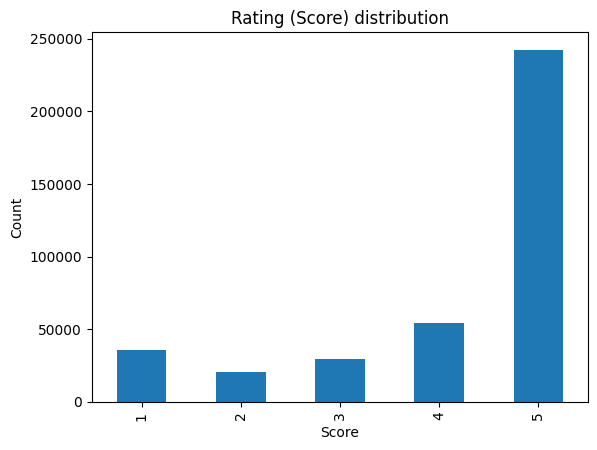

In [41]:
# score / sentiment distribution
df["Score"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating (Score) distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

Word-count hist → shows most reviews are short (<100 words)

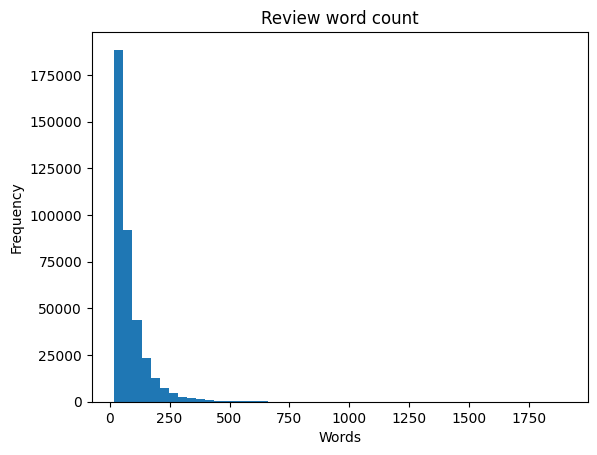

In [42]:
# word count distribution
df["word_count"].plot(kind="hist", bins=50)
plt.title("Review word count")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

Per-year bar → shows the data’s time range (nice for Data Understanding).

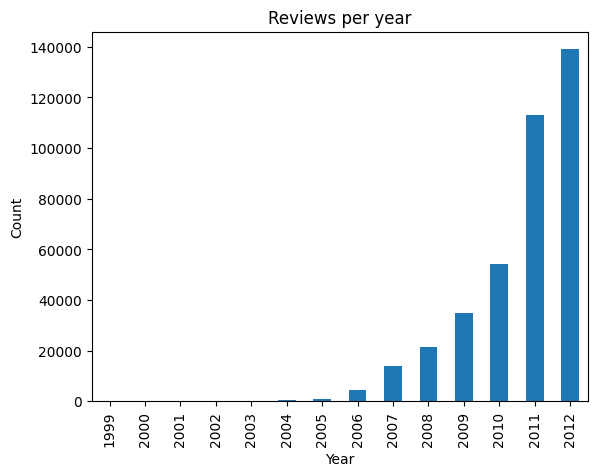

In [43]:
# review length over time (optional)
df.groupby(df["review_time"].dt.year)["Id"].count().plot(kind="bar")
plt.title("Reviews per year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

---
---

Saving it in a CSV file for modeling

In [44]:
df.to_csv("clean_amazon_reviews.csv", index=False)

In [45]:
from google.colab import files
files.download("clean_amazon_reviews.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>